# XNLI

### Compute Variance, Entropy, Mean Accuracy, Consistency, and Confusion matrix(by majority vote) per Language for XNLI Predictions
### Languages: ['en', 'el', 'bg', 'es', 'fr', 'th']


In [5]:
import os
import json
import numpy as np
import datetime
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from scipy.stats import entropy, mode

root_dir = '../xnli/raw_results/google/original'
language_order = ['en', 'el', 'bg', 'es', 'fr', 'th']
num_runs = 25
num_classes = 3

language_predictions = defaultdict(list)
language_true_labels = {}
language_accuracies = {}
language_consistency = {}
language_variances = {}
language_entropies = {}
language_confusion_matrices = {}


# Load Predictions + True Labels 
for run_num in range(1, num_runs + 1):
    run_folder = os.path.join(root_dir, f"run ({run_num})", "Pipeline", "output", "predicted")
    for i, lang in enumerate(language_order):
        filename = "predicted.json" if i == 0 else f"predicted_{i}.json"
        json_file = os.path.join(run_folder, filename)
        if not os.path.exists(json_file):
            continue
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            # Replace None with -1 so they can be handled numerically
            preds = np.array([p if p is not None else -1 for p in data['predicted']]).flatten()
            trues = np.array(data['true']).flatten()
            language_predictions[lang].append(preds)
            if run_num == 1:
                language_true_labels[lang] = trues

# Analysis
def prediction_entropy(pred_list):
    counts = np.bincount(pred_list, minlength=num_classes)
    probs = counts / np.sum(counts)
    return entropy(probs, base=2)

for lang in language_order:
    preds_runs = np.array(language_predictions[lang])  # (runs, samples)

    # Replace placeholder -1s for invalid values
    preds_runs = np.where(preds_runs == -1, np.nan, preds_runs)

    transposed = preds_runs.T  # (samples, runs)
    true_labels = language_true_labels[lang]

    # Label-based variance (raw label prediction variability)
    label_variance = np.nanvar(transposed, axis=1)
    language_variances[lang] = label_variance
    
    # Correctness-based variance (accuracy-based stability)
    # Create a correctness matrix: 1 if correct, 0 if wrong
    correctness_matrix = (transposed == true_labels[:, None]).astype(float)
    correctness_variance = np.nanvar(correctness_matrix, axis=1)
    language_variances[lang + "_correctness"] = correctness_variance

    # Entropy
    entropies = []
    for sample in transposed:
        sample_clean = sample[~np.isnan(sample)].astype(int)
        entropies.append(prediction_entropy(sample_clean))
    language_entropies[lang] = np.array(entropies)

    # Accuracy (ignore positions with NaNs)
    accs = []
    for run in preds_runs:
        mask = ~np.isnan(run)
        accs.append(np.mean(run[mask] == true_labels[mask]))
    language_accuracies[lang] = np.mean(accs)

    # Consistency (ignore -1)
    filled = np.nan_to_num(transposed, nan=-1).astype(int)
    most_common = mode(filled, axis=1, keepdims=True)[0].flatten()
    consistency = np.mean([
        np.mean((sample == most_common[i]) & (sample != -1))
        for i, sample in enumerate(filled)
    ])
    language_consistency[lang] = consistency

    # Confusion matrix
    # Majority vote over the runs (ignoring NaNs)
    majority_preds = []
    for preds_per_sample in transposed:
        preds_clean = preds_per_sample[~np.isnan(preds_per_sample)].astype(int)
        if len(preds_clean) == 0:
            majority_preds.append(-1)  # fallback
        else:
            most_common = mode(preds_clean, keepdims=False).mode
            majority_preds.append(most_common if most_common.size == 1 else most_common[0])
    
    majority_preds = np.array(majority_preds)
    
    # Filter out samples with invalid predictions
    valid_mask = majority_preds != -1
    y_true = true_labels[valid_mask]
    y_pred = majority_preds[valid_mask]
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    language_confusion_matrices[lang] = cm.tolist()

# Save
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = os.path.join("..", "xnli", "analysis", timestamp)
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, "summary.txt"), "w") as f:
    f.write("Language\tLabelVariance\tCorrectnessVariance\tEntropy\tAccuracy\tConsistency\n")
    for lang in language_order:
        f.write(f"{lang}\t"
                f"{np.mean(language_variances[lang]):.4f}\t"
                f"{np.mean(language_variances[lang + '_correctness']):.4f}\t"
                f"{np.mean(language_entropies[lang]):.4f}\t"
                f"{language_accuracies[lang]:.4f}\t"
                f"{language_consistency[lang]:.4f}\n")


with open(os.path.join(output_dir, "confusion_matrices.json"), "w") as f:
    json.dump(language_confusion_matrices, f, indent=2)

print(f"Metrics stored in {output_dir}")


Metrics stored in ..\xnli\analysis\20250728_084855


###  Bar Plot for Metrics

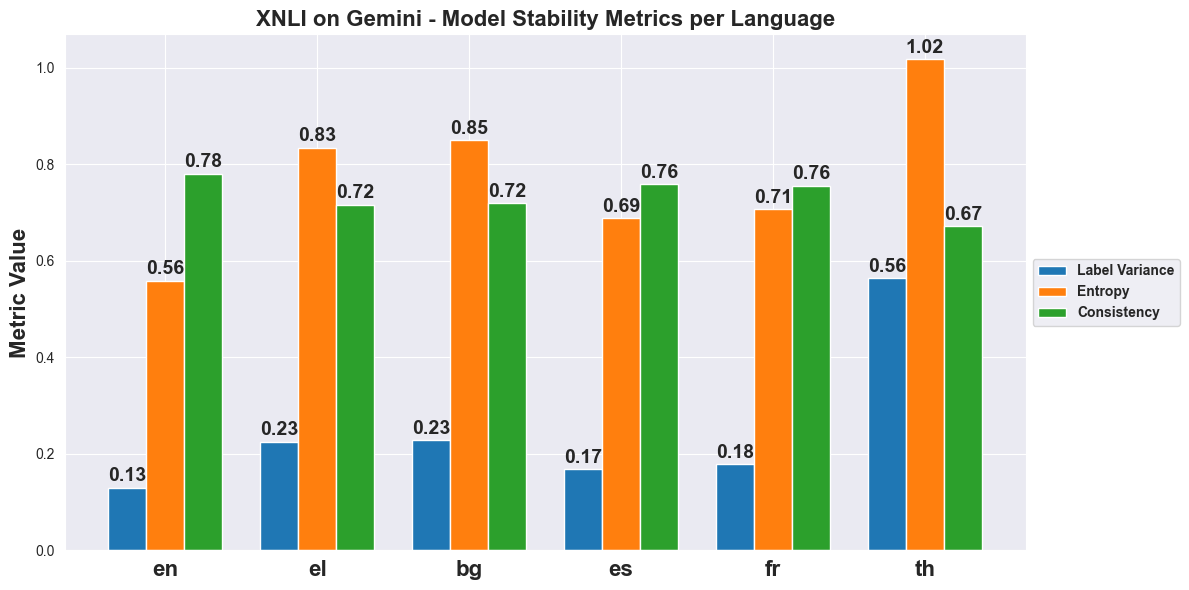

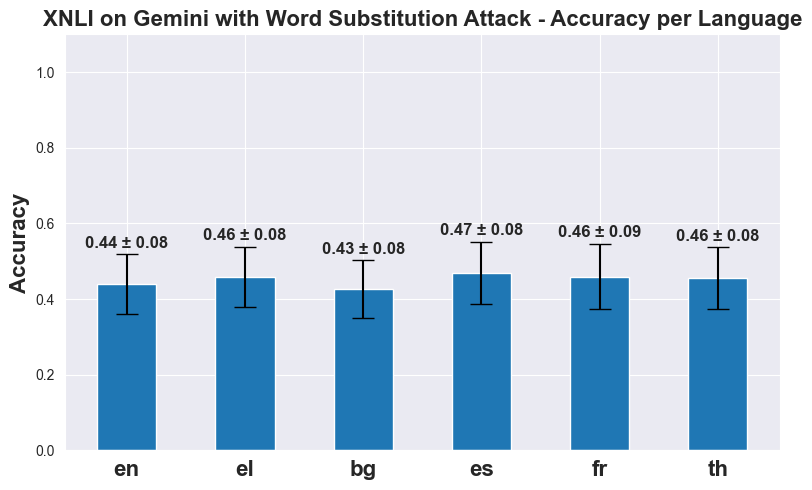

Plots saved in xnli\20250728_084930


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba

# Data setup
langs = language_order
variance_vals = [np.mean(language_variances[lang]) for lang in langs]
entropy_vals = [np.mean(language_entropies[lang]) for lang in langs]
accuracy_vals = [language_accuracies[lang] for lang in langs]
consistency_vals = [language_consistency[lang] for lang in langs]
correctness_stds = [np.std(language_variances[lang + '_correctness']) for lang in langs]

# Output folder
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
plot_dir = os.path.join("xnli", timestamp)
os.makedirs(plot_dir, exist_ok=True)

x = np.arange(len(langs))
width = 0.25
font_opts = {'fontsize': 16, 'fontweight': 'bold'}  # larger bold fonts

# === Plot 1: Variance, Entropy, Consistency ===
plt.figure(figsize=(12, 6))  # Keep full-size figure
bars1 = plt.bar(x - width, variance_vals, width, label='Label Variance')
bars2 = plt.bar(x, entropy_vals, width, label='Entropy')
bars3 = plt.bar(x + width, consistency_vals, width, label='Consistency')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.005,
                 f'{height:.2f}', ha='center', va='bottom',
                 fontsize=14, fontweight='bold')

plt.xticks(x, langs, **font_opts)
plt.ylabel("Metric Value", **font_opts)
plt.title("XNLI on Gemini - Model Stability Metrics per Language", **font_opts)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, prop={'weight': 'bold'})
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "stability_metrics.pdf"), dpi=300, bbox_inches='tight')
plt.show()

# === Plot 2: Accuracy with ± std error bars ===
plt.figure(figsize=(8, 5))  # Keep full-size figure
bars = plt.bar(x, accuracy_vals, width=0.5,
               yerr=correctness_stds, capsize=8, label='Accuracy')

for i, bar in enumerate(bars):
    height = bar.get_height()
    std = correctness_stds[i]
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + std + 0.01,
             f"{height:.2f} ± {std:.2f}", ha='center', va='bottom',
             fontsize=12, fontweight='bold')

plt.xticks(x, langs, **font_opts)
plt.ylabel("Accuracy", **font_opts)
plt.ylim(0, 1.1)
plt.title("XNLI on Gemini - Accuracy per Language", **font_opts)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "accuracy_with_std.pdf"), dpi=300, bbox_inches='tight')
plt.show()

print(f"Plots saved in {plot_dir}")


### Label Distribution Comparison (Predicted vs True)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14124\902088644.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


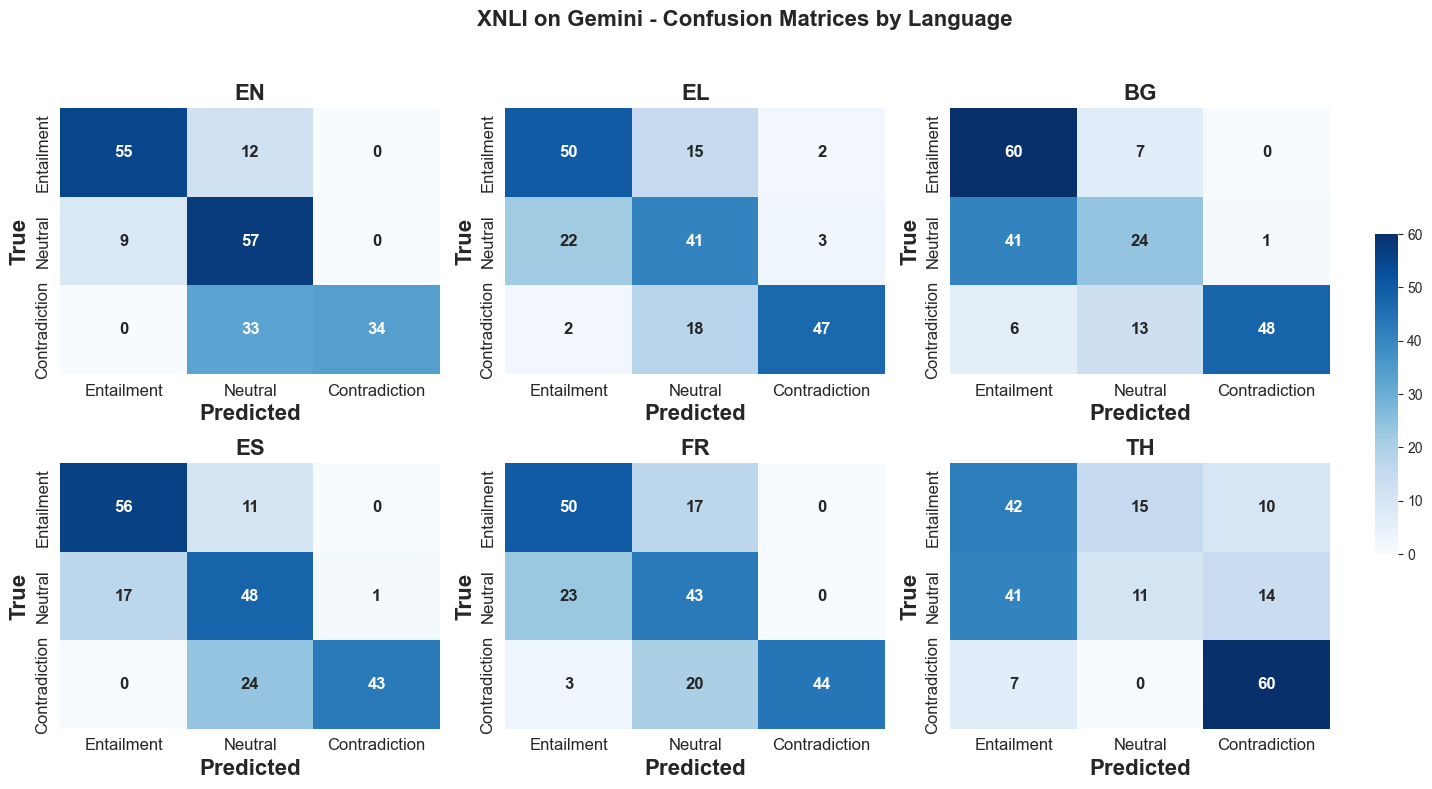

Confusion matrices saved to: xnli\20250528_194917\confusion_matrices.pdf


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime

# Class labels
class_labels = ["Entailment", "Neutral", "Contradiction"]

# Timestamp and output directory
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
plot_dir = os.path.join("xnli", timestamp)
os.makedirs(plot_dir, exist_ok=True)

# Subplot layout
num_langs = len(language_order)
cols = 3
rows = (num_langs + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

# Get global max count for color normalization
vmax = max(np.array(language_confusion_matrices[lang]).max() for lang in language_order if lang in language_confusion_matrices)

# Shared colorbar axis
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # right-hand colorbar

# Plot confusion matrices
for idx, lang in enumerate(language_order):
    ax = axes[idx]
    cm = language_confusion_matrices.get(lang)

    if cm is not None:
        sns.heatmap(cm,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    xticklabels=class_labels,
                    yticklabels=class_labels,
                    cbar=(idx == 0),
                    cbar_ax=cbar_ax if idx == 0 else None,
                    ax=ax,
                    vmin=0,
                    vmax=vmax,
                    annot_kws={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_title(f"{lang.upper()}", fontsize=16, fontweight='bold')
        ax.set_xlabel("Predicted", fontsize=16, fontweight='bold')
        ax.set_ylabel("True", fontsize=16, fontweight='bold')
        ax.tick_params(axis='both', labelsize=12)
    else:
        ax.axis('off')

# Hide any unused axes
for idx in range(num_langs, len(axes)):
    axes[idx].axis('off')

# Title and layout
fig.suptitle("XNLI on Gemini - Confusion Matrices by Language",
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

# Save
pdf_path = os.path.join(plot_dir, "confusion_matrices.pdf")
plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrices saved to: {pdf_path}")


# EUROPA

### Compute Mean LLM Judge Score and std in Scores


Analysis saved to ../europa_random_split/analysis\analysis_20250728_085140.txt


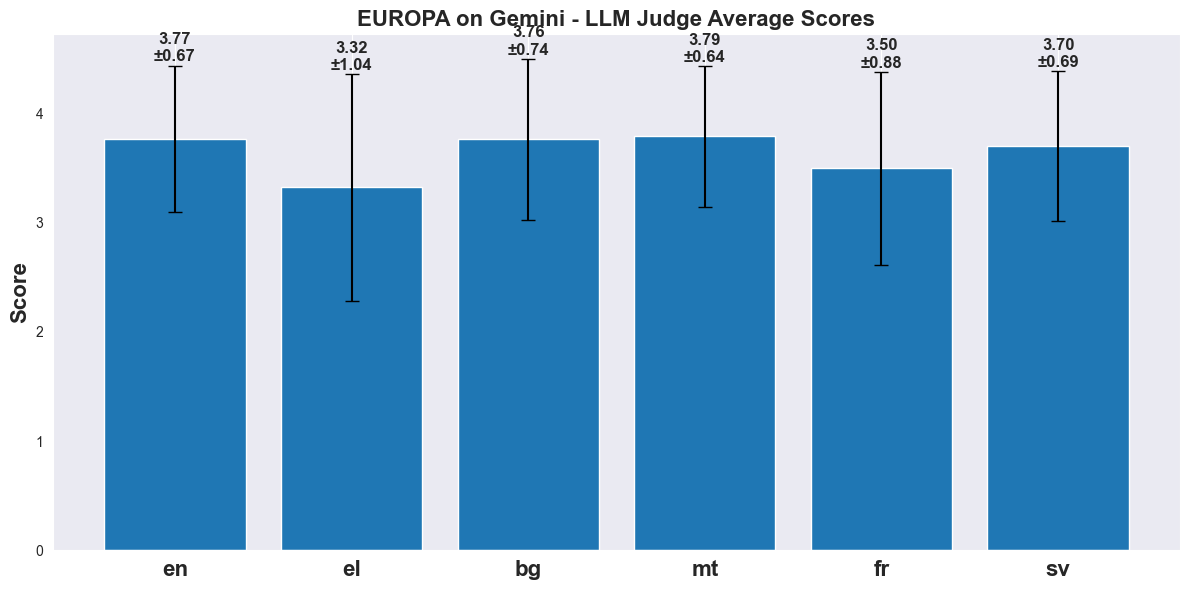

In [8]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load file
file_path = "../europa_random_split/raw_results/judge_responses.txt"
with open(file_path, "r", encoding="utf-8") as f:
    content = f.read()

# Parse language blocks
language_blocks = re.findall(r"==============Language: (\w+)=+.*?Parsed Numeric Scores:\n(.*?)(?=\n=|$)", content, re.DOTALL)

languages = []
means = []
stds = []

for lang, scores_str in language_blocks:
    scores = list(map(float, re.findall(r"\d+\.\d+", scores_str)))
    languages.append(lang)
    means.append(np.mean(scores))
    stds.append(np.std(scores))

# Plot
x = np.arange(len(languages))

plt.figure(figsize=(12, 6))
bars = plt.bar(x, means, yerr=stds, capsize=5)

# Annotate bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(
        x[i],
        mean + std + 0.01,
        f"{mean:.2f}\n±{std:.2f}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Styling
plt.xticks(x, languages, fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=16, fontweight='bold')
plt.title("EUROPA on Gemini - LLM Judge Average Scores", fontsize=16, fontweight='bold')
plt.grid(axis='y')

# Save analysis to file
output_dir = "../europa_random_split/analysis"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = os.path.join(output_dir, f"analysis_{timestamp}.txt")
with open(output_path, "w", encoding="utf-8") as out_file:
    out_file.write("Language\tMean Score\tStd Dev\n")
    for lang, mean, std in zip(languages, means, stds):
        out_file.write(f"{lang}\t{mean:.4f}\t{std:.4f}\n")

print(f"Analysis saved to {output_path}")

# Save figure
output_dir = "europa_random_split"
os.makedirs(output_dir, exist_ok=True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "europa.pdf"), format='pdf', bbox_inches='tight')
plt.show()


# XQUAD

### Compute Mean LLM Judge, BLEU, METEOR, Cosine Similarity Scores and Variances in each Score

In [9]:
import os
import re
import json
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from datetime import datetime

# Config
OUTPUT_DIR = "../xquad/analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = "../xquad/raw_results/google/original"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_CSV = os.path.join(OUTPUT_DIR, f"metrics_summary_{timestamp}.csv")

# Model
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
smoothing = SmoothingFunction().method1

# Files
lang_map = {
    "en": "predicted_en.json",
    "el": "predicted_el.json",
    "ar": "predicted_ar.json",
    "zh": "predicted_zh.json",
    "ru": "predicted_ru.json",
    "th": "predicted_th.json",
    "tr": "predicted_tr.json"
}

def load_predictions(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data["true"], data["predicted"]

def compute_metrics_for_language(lang, file_path):
    true_answers, predicted = load_predictions(file_path)
    bleu, meteor, cosine = [], [], []

    for ref_list, hyp in zip(true_answers, predicted):
        ref = ref_list[0] if ref_list else ""
        hyp = hyp.strip().lower() if hyp else ""
        ref = ref.strip().lower()

        if not hyp:
            bleu.append(0)
            meteor.append(0)
            cosine.append(0)
            continue

        try:
            bleu.append(sentence_bleu([word_tokenize(ref)], word_tokenize(hyp), smoothing_function=smoothing))
            meteor.append(meteor_score([word_tokenize(ref)], word_tokenize(hyp)))
        except:
            bleu.append(0)
            meteor.append(0)

        try:
            emb_ref = embedding_model.encode([ref])[0].reshape(1, -1)
            emb_hyp = embedding_model.encode([hyp])[0].reshape(1, -1)
            cosine.append(cosine_similarity(emb_ref, emb_hyp)[0][0])
        except:
            cosine.append(0)

    return {
        "Language": lang,
        "BLEU_Mean": np.mean(bleu),
        "BLEU_Var": np.var(bleu),
        "METEOR_Mean": np.mean(meteor),
        "METEOR_Var": np.var(meteor),
        "Cosine_Mean": np.mean(cosine),
        "Cosine_Var": np.var(cosine)
    }

def parse_judge_scores(judge_file):
    with open(judge_file, "r", encoding="utf-8") as f:
        content = f.read()
    blocks = re.findall(r"Language: (\w+).*?Parsed Numeric Scores:\n(.*?)(?=\n=|$)", content, re.DOTALL)
    results = []
    for lang, scores in blocks:
        vals = list(map(float, re.findall(r"\d+\.\d+", scores)))
        results.append({
            "Language": lang.strip(),
            "LLM_Judge_Mean": np.mean(vals),
            "LLM_Judge_Var": np.var(vals)
        })
    return pd.DataFrame(results)


metric_rows = []
for lang, fname in lang_map.items():
    path = os.path.join(DATA_DIR, fname)
    row = compute_metrics_for_language(lang, path)
    metric_rows.append(row)

metrics_df = pd.DataFrame(metric_rows)
judge_df = parse_judge_scores(os.path.join(DATA_DIR, "judge_responses.txt"))

final_df = pd.merge(metrics_df, judge_df, on="Language", how="left")
final_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved results to {OUTPUT_CSV}")



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\Gebruiker\Documents\GitHub\Legal-Multilingual-Evaluation-of-LLMs\interp\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Gebruiker\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]


KeyboardInterrupt



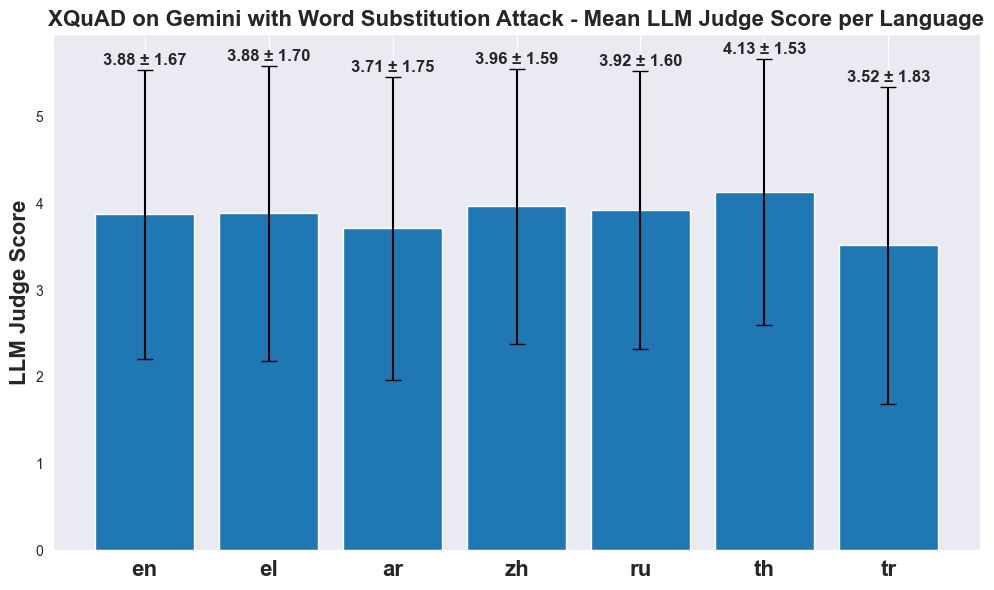

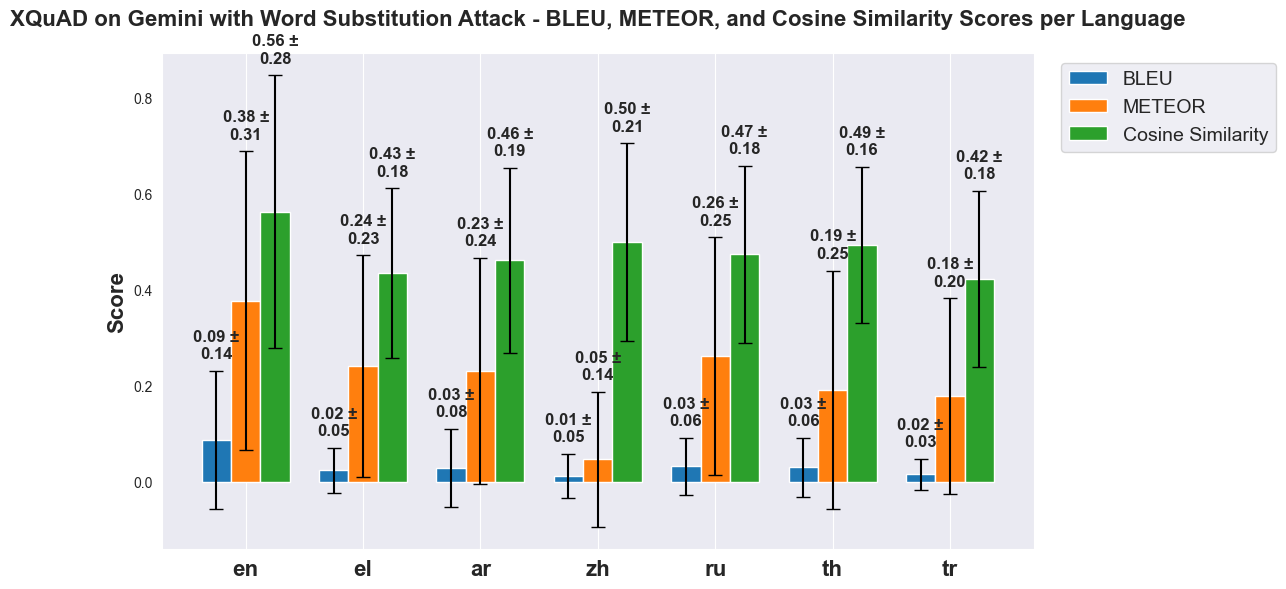

Saved plots to xquad\20250728_090948


In [2]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Setup output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = os.path.join("xquad", timestamp)
os.makedirs(output_dir, exist_ok=True)

def plot_llm_judge_scores(df, save_path=None):
    languages = df["Language"]
    means = df["LLM_Judge_Mean"]
    stds = np.sqrt(df["LLM_Judge_Var"])
    x = np.arange(len(languages))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(x, means, yerr=stds, capsize=6, label='LLM Judge Score')

    for i, (mean, std) in enumerate(zip(means, stds)):
        label = f"{mean:.2f} ± {std:.2f}"
        plt.text(x[i], mean + std + 0.02, label, ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.xticks(x, languages, fontsize=16, fontweight='bold')
    plt.ylabel("LLM Judge Score", fontsize=16, fontweight='bold')
    plt.title("XQuAD on Gemini - Mean LLM Judge Score per Language",
              fontsize=16, fontweight='bold')
    plt.grid(axis='y')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_grouped_metrics(df, metrics, save_path=None):
    languages = df["Language"]
    x = np.arange(len(languages))
    width = 0.25

    plt.figure(figsize=(12, 6))
    for i, (mean_col, var_col, label, color) in enumerate(metrics):
        means = df[mean_col]
        stds = np.sqrt(df[var_col])
        offset = (i - 1) * width
        bars = plt.bar(x + offset, means, width, yerr=stds, capsize=5, label=label)

        for j, (mean, std) in enumerate(zip(means, stds)):
            label_text = f"{mean:.2f} ±\n{std:.2f}"
            plt.text(x[j] + offset, mean + std + 0.02, label_text, ha='center', va='bottom',
                     fontsize=12, fontweight='bold')

    plt.xticks(x, languages, fontsize=16, fontweight='bold')
    plt.ylabel("Score", fontsize=16, fontweight='bold')
    plt.title("XQuAD on Gemini - BLEU, METEOR, and Cosine Similarity Scores per Language",
              fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14)
    plt.grid(axis='y')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Load the latest metrics CSV
csv_files = glob.glob("../xquad/analysis/metrics_summary_*.csv")
latest_csv = max(csv_files, key=os.path.getctime)
df = pd.read_csv(latest_csv)

# Save and plot LLM Judge
plot_llm_judge_scores(df, save_path=os.path.join(output_dir, "llm_judge_scores.pdf"))

# Save and plot grouped metrics
metric_list = [
    ("BLEU_Mean", "BLEU_Var", "BLEU", 'cornflowerblue'),
    ("METEOR_Mean", "METEOR_Var", "METEOR", 'mediumseagreen'),
    ("Cosine_Mean", "Cosine_Var", "Cosine Similarity", 'salmon')
]
plot_grouped_metrics(df, metric_list, save_path=os.path.join(output_dir, "metric_scores_grouped.pdf"))

print(f"Saved plots to {output_dir}")


# MultiEURLEX

### Compute Precision, Recall, F1, Mean R-Precision and graph it

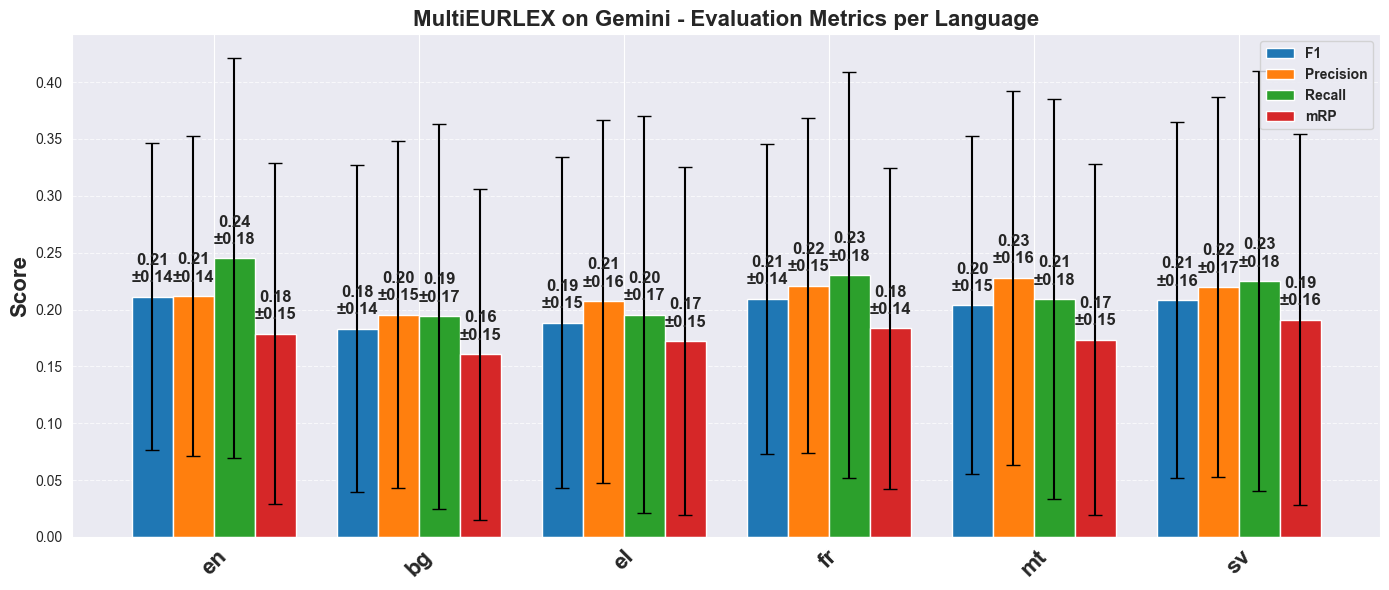

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import defaultdict

def mean_r_precision(y_true, y_pred):
    r_precisions = []
    for true_labels, pred_labels in zip(y_true, y_pred):
        k = len(true_labels)
        top_k_preds = pred_labels[:k]
        r_precision = len(set(top_k_preds) & set(true_labels)) / k if k else 0
        r_precisions.append(r_precision)
    return r_precisions

def evaluate_metrics(y_true, y_pred):
    all_labels = list(set(label for sublist in y_true + y_pred for label in sublist))
    label_to_idx = {label: i for i, label in enumerate(all_labels)}

    def binarize(labels):
        return [1 if label in labels else 0 for label in all_labels]

    y_true_bin = [binarize(lbls) for lbls in y_true]
    y_pred_bin = [binarize(lbls) for lbls in y_pred]

    precisions = []
    recalls = []
    f1s = []
    mrps = mean_r_precision(y_true, y_pred)

    for y_t, y_p in zip(y_true_bin, y_pred_bin):
        prec = precision_score([y_t], [y_p], average='samples', zero_division=0)
        rec = recall_score([y_t], [y_p], average='samples', zero_division=0)
        f1 = f1_score([y_t], [y_p], average='samples', zero_division=0)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    return {
        'Precision': (np.mean(precisions), np.var(precisions)),
        'Recall': (np.mean(recalls), np.var(recalls)),
        'F1': (np.mean(f1s), np.var(f1s)),
        'mRP': (np.mean(mrps), np.var(mrps))
    }

def process_folder(folder_path):
    metrics_by_language = {}

    for file_name in os.listdir(folder_path):
        if file_name.startswith('predicted') and file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as f:
                data = json.load(f)

            language = data.get('language', 'unknown')
            y_true = data.get('true', [])
            y_pred = data.get('predicted', [])

            metrics_by_language[language] = evaluate_metrics(y_true, y_pred)

    languages = sorted(metrics_by_language.keys(), key=lambda x: (x != 'en', x))
    metric_names = ['F1', 'Precision', 'Recall', 'mRP']
    avg_metrics = {m: [] for m in metric_names}
    var_metrics = {m: [] for m in metric_names}

    for lang in languages:
        metrics = metrics_by_language[lang]
        for metric in metric_names:
            mean, var = metrics[metric]
            avg_metrics[metric].append(mean)
            var_metrics[metric].append(var)

    x = np.arange(len(languages))
    width = 0.2
    fig, ax = plt.subplots(figsize=(14, 6))

    for i, metric in enumerate(metric_names):
        means = avg_metrics[metric]
        stds = np.sqrt(var_metrics[metric])
        positions = x + i * width
        bars = ax.bar(positions, means, width, yerr=stds, capsize=5, label=metric)

        for bar, mean, std in zip(bars, means, stds):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.01,
                f"{mean:.2f}\n±{std:.2f}",
                ha='center',
                va='bottom',
                fontsize=12,
                fontweight='bold'
            )

    ax.set_ylabel('Score', fontsize=16, fontweight='bold')
    ax.set_title('MultiEURLEX on Gemini - Evaluation Metrics per Language', fontsize=16, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(languages, rotation=45, fontsize=16, fontweight='bold')
    ax.legend(fontsize=14, prop={'weight': 'bold'})
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    output_dir = "multi_eurlex"
    os.makedirs(output_dir, exist_ok=True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "multi_eurlex.pdf"), format='pdf', bbox_inches='tight')
    plt.show()

process_folder('../multi_eurlex/raw_results/google/predicted')


# Terms of Service

### Plots accuracy and a penalty rating  which quantifies the severity of model misclassifications by assigning a score of 0 for correct predictions, 0.5 for near misses (e.g., confusing "clearly unfair" with "potentially unfair"), and 1.0 for severe errors (e.g., mistaking "clearly unfair" for "clearly fair"). Create confusion matrices


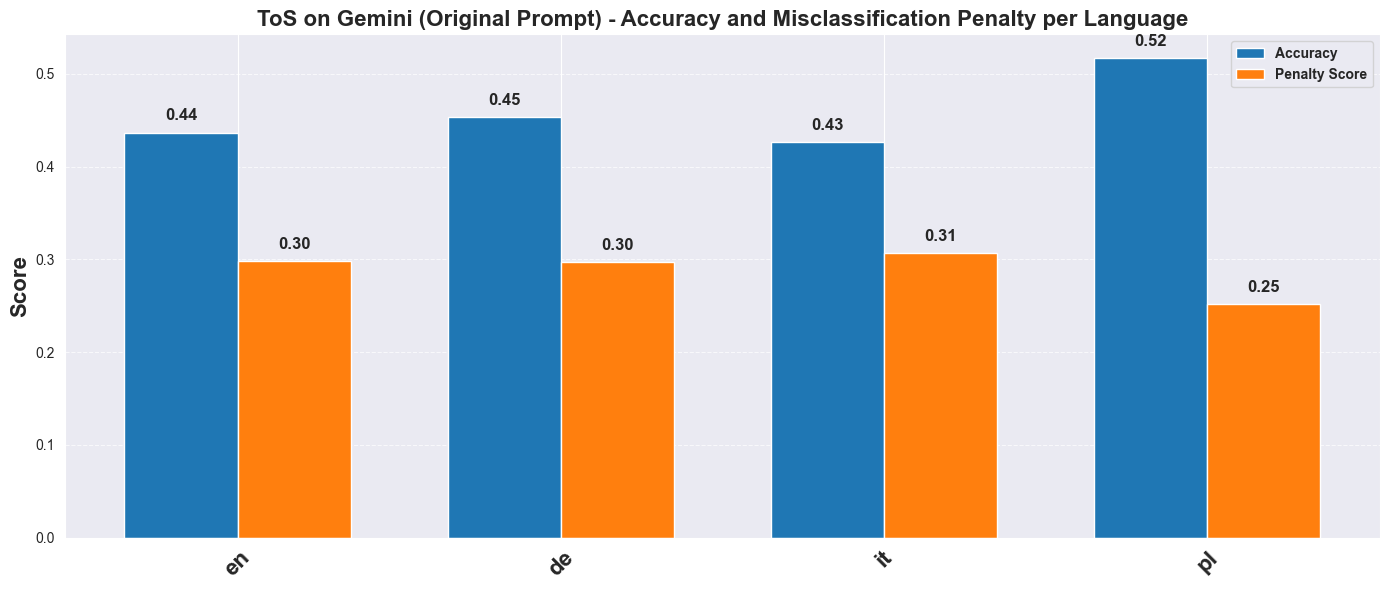

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14124\4095074539.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


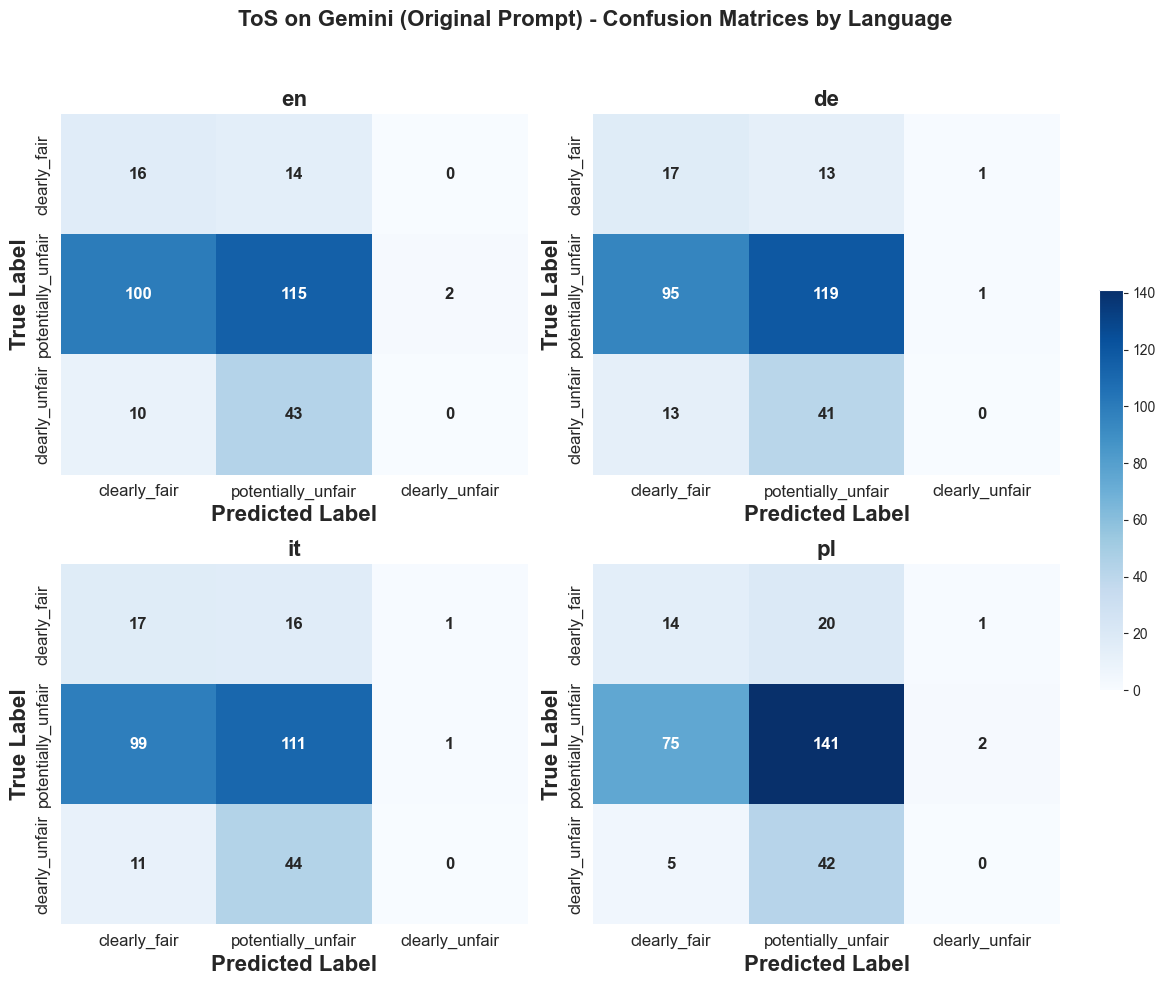

Analysis complete. Results saved to: ../terms_of_service/analysis


In [38]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import confusion_matrix


def compute_penalty(y_true, y_pred):
    penalties = []
    for t, p in zip(y_true, y_pred):
        if t == p:
            penalties.append(0.0)
        elif abs(t - p) == 1:
            penalties.append(0.5)
        else:
            penalties.append(1.0)
    return np.mean(penalties)

def process_classification_results(folder_path):
    accuracies = {}
    penalties = {}
    confusion_matrices = {}

    for file_name in os.listdir(folder_path):
        if file_name.startswith("predicted") and file_name.endswith(".json"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as f:
                data = json.load(f)

            lang = data.get('language', 'unknown')
            y_true = data.get('true', [])
            y_pred = data.get('predicted', [])

            # Flatten and clean labels
            y_true_flat = []
            y_pred_flat = []
            
            for yt, yp in zip(y_true, y_pred):
                try:
                    true_label = int(yt[0]) if isinstance(yt, list) else int(yt)
                    pred_label = int(yp[0]) if isinstance(yp, list) else int(yp)
                except (ValueError, TypeError, IndexError):
                    # If invalid, count as a completely wrong guess
                    y_true_flat.append(0)
                    y_pred_flat.append(2)
                else:
                    y_true_flat.append(true_label)
                    y_pred_flat.append(pred_label)


            # Valid data → compute scores
            acc = np.mean([t == p for t, p in zip(y_true_flat, y_pred_flat)])
            penalty = compute_penalty(y_true_flat, y_pred_flat)
            conf = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2]).tolist()

            accuracies[lang] = acc
            penalties[lang] = penalty
            confusion_matrices[lang] = conf

    # Sort languages with 'en' first
    sorted_langs = sorted(accuracies.keys(), key=lambda x: (x != 'en', x))
    return sorted_langs, accuracies, penalties, confusion_matrices


def plot_combined_scores(languages, accuracies, penalties, _):
    x = np.arange(len(languages))
    width = 0.35

    acc_values = [accuracies[lang] for lang in languages]
    pen_values = [penalties[lang] for lang in languages]

    fig, ax = plt.subplots(figsize=(14, 6))
    acc_bars = ax.bar(x - width/2, acc_values, width, label='Accuracy')
    pen_bars = ax.bar(x + width/2, pen_values, width, label='Penalty Score')

    for bars, values in [(acc_bars, acc_values), (pen_bars, pen_values)]:
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, val + 0.01, f"{val:.2f}",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax.set_xticks(x)
    ax.set_xticklabels(languages, rotation=45, fontsize=16, fontweight='bold')
    ax.set_ylabel('Score', fontsize=16, fontweight='bold')
    ax.set_title('ToS on Gemini (Original Prompt) - Accuracy and Misclassification Penalty per Language',
                 fontsize=16, fontweight='bold')
    ax.legend(fontsize=14, prop={'weight': 'bold'})
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join("terms_of_service", f"scores_per_language_{timestamp}.pdf")
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', format='pdf')
    plt.show()




def save_results_text(languages, accuracies, penalties, filepath):
    with open(filepath, "w", encoding="utf-8") as f:
        f.write("Language\tAccuracy\tPenalty\n")
        for lang in languages:
            f.write(f"{lang}\t{accuracies[lang]:.4f}\t{penalties[lang]:.4f}\n")

def save_confusion_matrices(confusion_data, filepath):
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(confusion_data, f, indent=2)


def plot_confusion_matrices_grid(confusion_data, languages, output_dir):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('ToS on Gemini (Original Prompt) - Confusion Matrices by Language',
                 fontsize=16, fontweight='bold')

    labels = ["clearly_fair", "potentially_unfair", "clearly_unfair"]
    axes = axes.flatten()

    # Get global vmin/vmax for consistent scale
    all_vals = [val for lang in languages for row in confusion_data[lang] for val in row]
    vmin, vmax = min(all_vals), max(all_vals)

    # Use a hidden reference heatmap for colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
    sm.set_array([])

    for ax, lang in zip(axes, languages):
        matrix = np.array(confusion_data[lang])[:3, :3]
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=ax,
                    vmin=vmin, vmax=vmax,
                    annot_kws={'fontsize': 12, 'fontweight': 'bold'})

        ax.set_title(lang, fontsize=16, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=16, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=16, fontweight='bold')
        ax.tick_params(axis='both', labelsize=12)

    for i in range(len(languages), len(axes)):
        fig.delaxes(axes[i])  # remove unused axes

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    fig.colorbar(sm, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join("terms_of_service", f"confusion_matrices_{timestamp}.pdf")
    plt.savefig(out_path, format='pdf', bbox_inches='tight')
    plt.show()



def main():
    input_folder = "../terms_of_service/raw_results/google/original"
    output_folder = "../terms_of_service/analysis"
    os.makedirs(output_folder, exist_ok=True)

    languages, accuracies, penalties, confusion_matrices = process_classification_results(input_folder)

    save_results_text(languages, accuracies, penalties, os.path.join(output_folder, "summary.txt"))
    save_confusion_matrices({lang: confusion_matrices[lang] for lang in languages},
                            os.path.join(output_folder, "confusion_matrices.json"))

    plot_combined_scores(languages, accuracies, penalties, output_folder)

    plot_confusion_matrices_grid(confusion_matrices, languages[:4], output_folder)


    print("Analysis complete. Results saved to:", output_folder)

if __name__ == "__main__":
    main()


# LEXam Open Questions

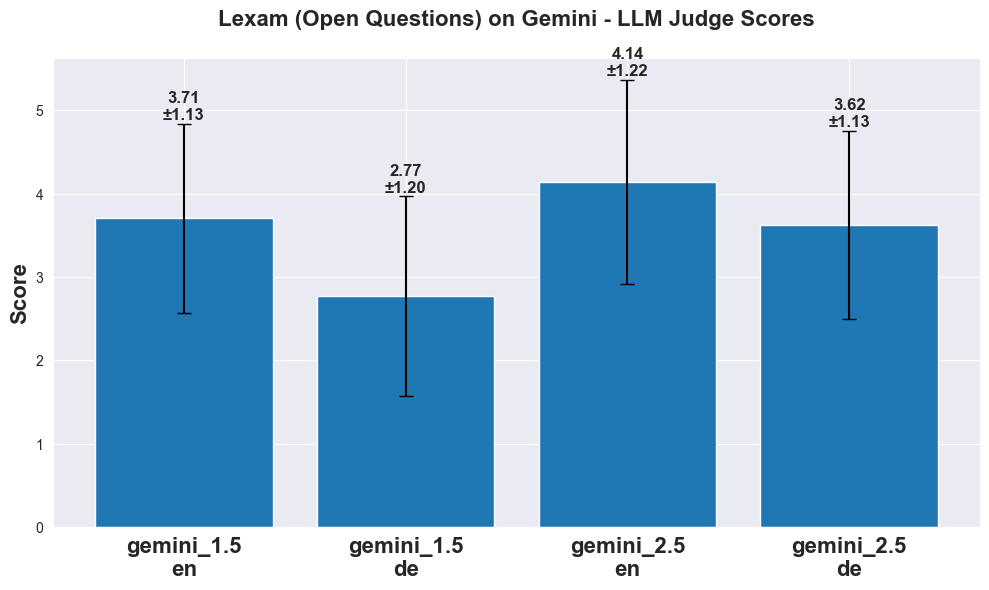

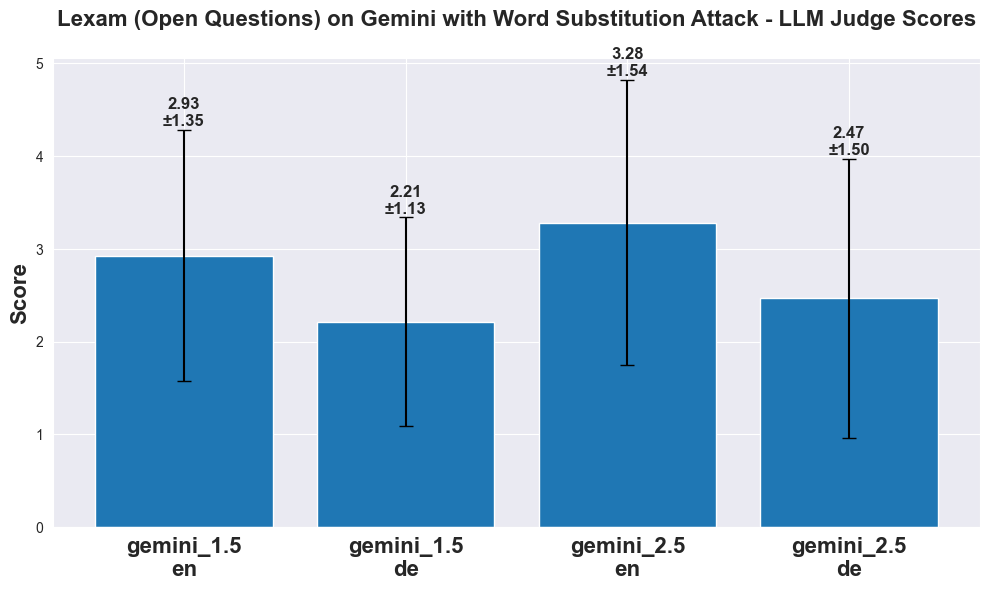

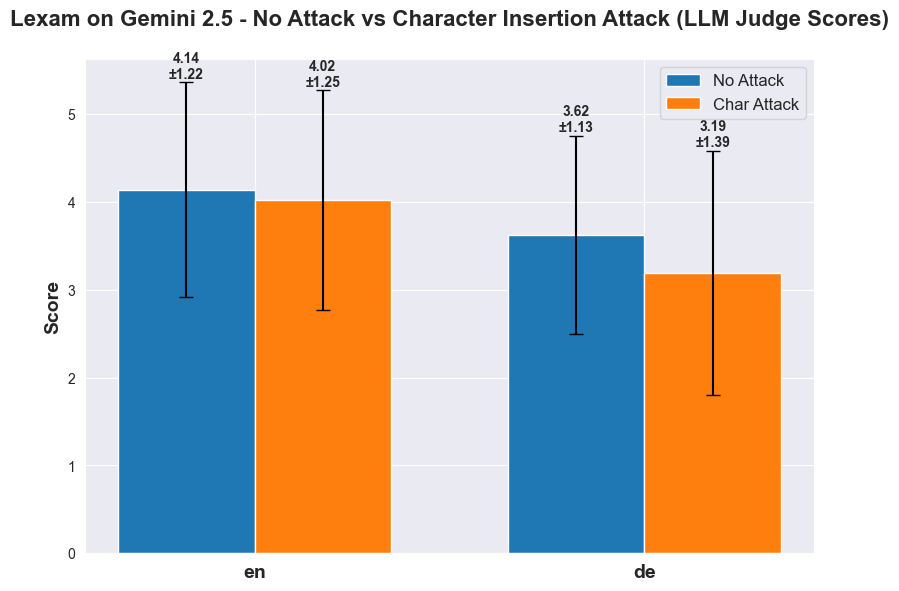

In [4]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Configuration
base_dir = "../lexam/open/"
models = ["gemini_1.5", "gemini_2.5"]
languages = ["en", "de"]
attack_types = ["clean", "attack", "attack_char"] 

# Utility to parse judge response scores
def parse_scores(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()
    scores = list(map(float, re.findall(r"\d+\.\d+", content)))
    return np.mean(scores), np.std(scores)

# Gather results
results = {attack: {model: {} for model in models} for attack in attack_types}

for model in models:
    model_dir = os.path.join(base_dir, model)
    for fname in os.listdir(model_dir):
        if not fname.startswith("judge_responses_") or "mc" in fname:
            continue

        lang_match = re.match(r"judge_responses_(en|de)(?:_attack(?:_char)?)?\.txt", fname)
        if not lang_match:
            continue
        lang = lang_match.group(1)

        if "_attack_char" in fname:
            attack = "attack_char"
        elif "_attack" in fname:
            attack = "attack"
        else:
            attack = "clean"

        file_path = os.path.join(model_dir, fname)
        mean, std = parse_scores(file_path)
        results[attack][model][lang] = (mean, std)

# Plot a single condition (clean or word attack)
def plot_results(results_dict, attack_label):
    x_labels, means, stds = [], [], []

    for model in models:
        for lang in languages:
            x_labels.append(f"{model}\n{lang}")
            mean, std = results_dict[model].get(lang, (0, 0))
            means.append(mean)
            stds.append(std)

    x = np.arange(len(x_labels))
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x, means, yerr=stds, capsize=5)

    for i, (mean, std) in enumerate(zip(means, stds)):
        plt.text(x[i], mean + std + 0.01, f"{mean:.2f}\n±{std:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.xticks(x, x_labels, fontsize=16, fontweight='bold')
    plt.ylabel("Score", fontsize=16, fontweight='bold')

    title = "Lexam (Open Questions) on Gemini"
    if attack_label == "attack":
        title += " with Word Substitution Attack"
    title += " - LLM Judge Scores"

    plt.title(title, fontsize=16, fontweight='bold', y=1.05)

    output_dir = "lexam"
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"lexam_open_{attack_label}_{timestamp}.pdf"

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
    plt.show()

# Plot Gemini 2.5 only: clean vs char attack
def plot_gemini25_clean_vs_char(results):
    model = "gemini_2.5"
    x_labels, clean_means, char_means, clean_stds, char_stds = [], [], [], [], []

    for lang in languages:
        x_labels.append(lang)
        mean_c, std_c = results["clean"][model].get(lang, (0, 0))
        mean_a, std_a = results["attack_char"][model].get(lang, (0, 0))

        clean_means.append(mean_c)
        clean_stds.append(std_c)
        char_means.append(mean_a)
        char_stds.append(std_a)

    x = np.arange(len(x_labels))
    bar_width = 0.35
    plt.figure(figsize=(8, 6))

    plt.bar(x - bar_width / 2, clean_means, width=bar_width, yerr=clean_stds, capsize=5, label='No Attack')
    plt.bar(x + bar_width / 2, char_means, width=bar_width, yerr=char_stds, capsize=5, label='Char Attack')

    for i in range(len(x_labels)):
        for offset, (mean, std) in zip([-bar_width / 2, bar_width / 2], [
            (clean_means[i], clean_stds[i]),
            (char_means[i], char_stds[i]),
        ]):
            plt.text(x[i] + offset, mean + std + 0.01, f"{mean:.2f}\n±{std:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(x, x_labels, fontsize=14, fontweight='bold')
    plt.ylabel("Score", fontsize=14, fontweight='bold')
    plt.title("Lexam on Gemini 2.5 - No Attack vs Character Insertion Attack (LLM Judge Scores)", fontsize=16, fontweight='bold', y=1.05)
    plt.legend(fontsize=12)

    output_dir = "lexam"
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"lexam_open_gemini25_charonly_{timestamp}.pdf"

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
    plt.show()

# Run all plots
plot_results(results["clean"], "clean")
plot_results(results["attack"], "attack")
plot_gemini25_clean_vs_char(results)


# LEXam Multiple Choice

### For Gemini-2.5-flash, the answer sometimes were not in the asked format which is ###ANSWER###, therefore our script could not get the answer so some processing was done to the answers to transform the answer given into the format ###ANSWER###. The below code gets the new file with the transformed answers and the file with the true answers and creates a predicted file, similar to the rest of the datasets.

In [5]:
import os
import json
import re

def extract_answers_from_log(file_path):
    pattern = re.compile(r'^(\d+):.*?###([ABCD])###', re.MULTILINE | re.DOTALL)
    answers = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        for match in pattern.finditer(content):
            idx = int(match.group(1))
            answer = match.group(2)
            answers[idx] = 'ABCD'.index(answer)
    return answers

def pad_predictions(answers_dict, length):
    return [answers_dict.get(i, None) for i in range(length)]

def process_files(directory):
    for filename in os.listdir(directory):
        if filename.startswith("out_") and filename.endswith(".txt"):
            log_path = os.path.join(directory, filename)
            lang_attack = filename[len("out_"):-len(".txt")]
            true_json_name = f"true_{lang_attack}.json"
            true_json_path = os.path.join(directory, true_json_name)
            predicted_json_name = f"predicted_{lang_attack}.json"
            predicted_json_path = os.path.join(directory, predicted_json_name)

            if not os.path.exists(true_json_path):
                print(f"Missing JSON file for {filename}, skipping.")
                continue

            print(f"Processing {filename} → {predicted_json_name}")

            answers_dict = extract_answers_from_log(log_path)

            with open(true_json_path, 'r', encoding='utf-8') as jf:
                data = json.load(jf)
                length = len(data["true"])
                predicted = pad_predictions(answers_dict, length)
                data["predicted"] = predicted

            with open(predicted_json_path, 'w', encoding='utf-8') as pf:
                json.dump(data, pf, indent=2)

            print(f"Saved predicted results to {predicted_json_name}")

if __name__ == "__main__":
    target_dir = '../lexam/mc/gemini_2.5'
    process_files(target_dir)


Processing out_de.txt → predicted_de.json
Saved predicted results to predicted_de.json
Processing out_de_attack.txt → predicted_de_attack.json
Saved predicted results to predicted_de_attack.json
Processing out_de_attack_char.txt → predicted_de_attack_char.json
Saved predicted results to predicted_de_attack_char.json
Processing out_en.txt → predicted_en.json
Saved predicted results to predicted_en.json
Processing out_en_attack.txt → predicted_en_attack.json
Saved predicted results to predicted_en_attack.json
Processing out_en_attack_char.txt → predicted_en_attack_char.json
Saved predicted results to predicted_en_attack_char.json


### Now that the files are ready, the graphs can be created

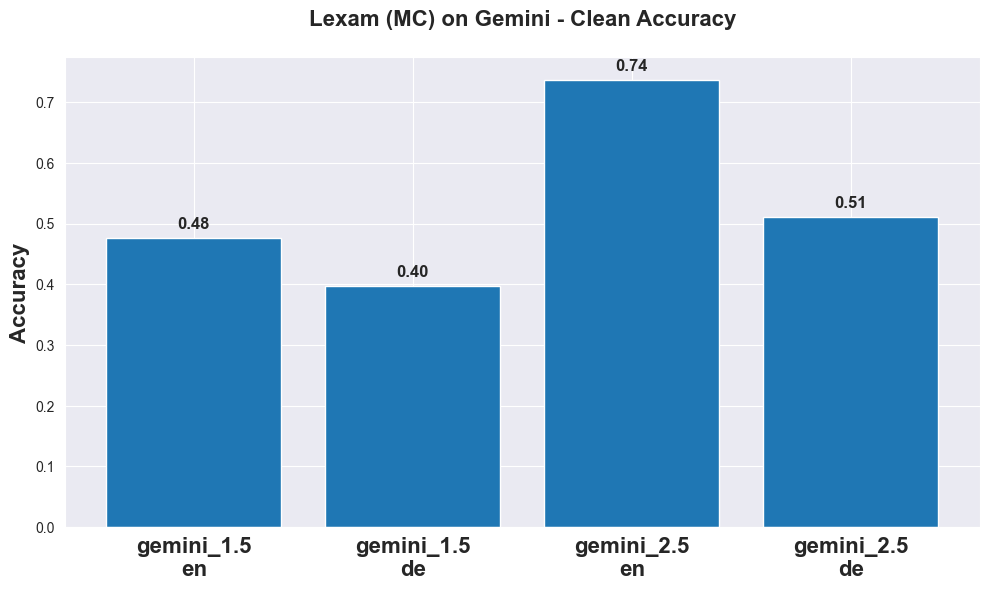

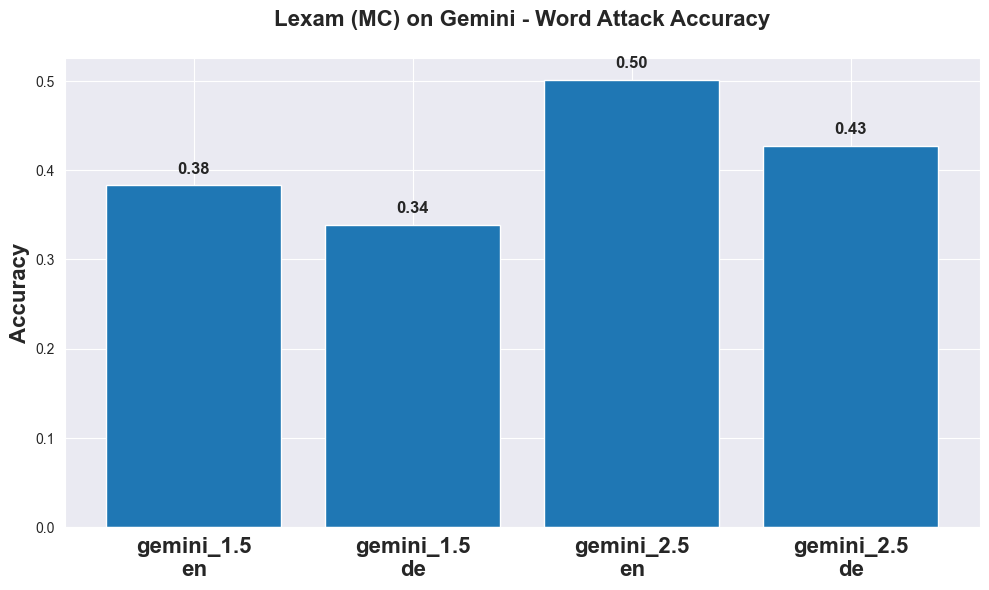

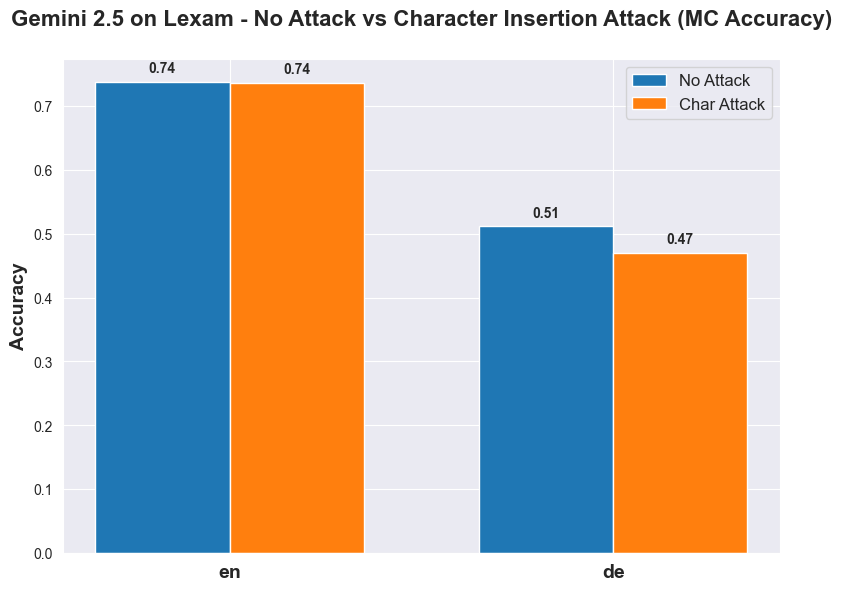

In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Configuration
base_dir = "../lexam/mc/"
models = ["gemini_1.5", "gemini_2.5"]
languages = ["en", "de"]
attack_types = ["clean", "attack_word", "attack_char"]

# Gather results
results = {attack: {model: {} for model in models} for attack in attack_types}

for model in models:
    model_dir = os.path.join(base_dir, model)
    for fname in os.listdir(model_dir):
        if not fname.startswith("predicted_") or not fname.endswith(".json"):
            continue

        lang = "en" if "en" in fname else "de"
        if "_attack_char" in fname:
            attack = "attack_char"
        elif "_attack" in fname:
            attack = "attack_word"
        else:
            attack = "clean"

        path = os.path.join(model_dir, fname)
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
            true = np.array(data["true"])
            pred = np.array(data["predicted"])
            mask = pred != None
            accuracy = (pred[mask] == true[mask]).mean() if np.any(mask) else 0.0

        results[attack][model][lang] = accuracy

# Plot a single result (clean or attack_word)
def plot_single_condition(results_dict, label):
    x_labels = []
    accuracies = []

    for model in models:
        for lang in languages:
            x_labels.append(f"{model}\n{lang}")
            acc = results_dict[model].get(lang, 0.0)
            accuracies.append(acc)

    x = np.arange(len(x_labels))
    plt.figure(figsize=(10, 6))
    plt.bar(x, accuracies)

    for i, acc in enumerate(accuracies):
        plt.text(x[i], acc + 0.01, f"{acc:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.xticks(x, x_labels, fontsize=16, fontweight='bold')
    plt.ylabel("Accuracy", fontsize=16, fontweight='bold')

    title = "Lexam (MC) on Gemini - "
    title += "Clean Accuracy" if label == "clean" else "Word Attack Accuracy"
    plt.title(title, fontsize=16, fontweight='bold', y=1.05)

    output_dir = "lexam"
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"lexam_mc_{label}_{timestamp}.pdf"

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
    plt.show()

# Gemini 2.5: clean vs char attack
def plot_gemini25_clean_vs_char(results):
    model = "gemini_2.5"
    x_labels = []
    clean_acc = []
    char_acc = []

    for lang in languages:
        x_labels.append(lang)
        clean = results["clean"][model].get(lang, 0.0)
        char = results["attack_char"][model].get(lang, 0.0)
        clean_acc.append(clean)
        char_acc.append(char)

    x = np.arange(len(x_labels))
    bar_width = 0.35
    plt.figure(figsize=(8, 6))

    plt.bar(x - bar_width / 2, clean_acc, width=bar_width, label='No Attack')
    plt.bar(x + bar_width / 2, char_acc, width=bar_width, label='Char Attack')

    for i in range(len(x_labels)):
        for offset, acc in zip([-bar_width / 2, bar_width / 2], [clean_acc[i], char_acc[i]]):
            plt.text(x[i] + offset, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(x, x_labels, fontsize=14, fontweight='bold')
    plt.ylabel("Accuracy", fontsize=14, fontweight='bold')
    plt.title("Gemini 2.5 on Lexam - No Attack vs Character Insertion Attack (MC Accuracy)", fontsize=16, fontweight='bold', y=1.05)
    plt.legend(fontsize=12)

    output_dir = "lexam"
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"lexam_mc_gemini25_charonly_{timestamp}.pdf"

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
    plt.show()

# Generate the 3 plots
plot_single_condition(results["clean"], "clean")
plot_single_condition(results["attack_word"], "attack_word")
plot_gemini25_clean_vs_char(results)
